### 1. oauth_login()

In [14]:
# Define ‘starting point’
screen_name='CuteCatOnline'

import twitter
def oauth_login():
    # TwitterAPI_alpha
    CONSUMER_KEY = '*************************'
    CONSUMER_SECRET = '*************************'
    OAUTH_TOKEN = '*************************'
    OAUTH_TOKEN_SECRET = '*************************'
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

In [15]:
twitter_api = oauth_login()
twitter_api

### 2. make_twitter_request

In [16]:
import sys
import time
from urllib.error import URLError
from http.client import BadStatusLine
import json
import twitter

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw): 
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e
        # See https://developer.twitter.com/en/docs/basics/response-codes for common codes
        if e.e.code == 401:
            print('Encountered 401 Error (Not Authorized)', file=sys.stderr)
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429: 
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered {0} Error. Retrying in {1} seconds'                  .format(e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e
    # End of nested helper function
    
    wait_period = 2 
    error_count = 0 

    while True:
        try:
            return twitter_api_func(*args, **kw)
        except twitter.api.TwitterHTTPError as e:
            error_count = 0 
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print("BadStatusLine encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise

### 3. get_user_profile

In [17]:
def get_user_profile(twitter_api, screen_names=None, user_ids=None):
    # Must have either screen_name or user_id (logical xor)
    assert (screen_names != None) != (user_ids != None),     "Must have screen_names or user_ids, but not both"
    items_to_info = {}
    items = screen_names or user_ids
    while len(items) > 0:
        # Process 100 items at a time per the API specifications for /users/lookup.
        # See http://bit.ly/2Gcjfzr for details.
        items_str = ','.join([str(item) for item in items[:100]])
        items = items[100:]
        if screen_names:
            response = make_twitter_request(twitter_api.users.lookup, screen_name=items_str)
        else: # user_ids
            response = make_twitter_request(twitter_api.users.lookup, user_id=items_str)    
        for user_info in response:
            if screen_names:
                items_to_info[user_info['screen_name']] = user_info
            else: # user_ids
                items_to_info[user_info['id']] = user_info
    return items_to_info

### 4. get_friends_followers_ids

In [18]:
# Retrieve friends
from functools import partial
from sys import maxsize as maxint

def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                              friends_limit=maxint, followers_limit=maxint):
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None),     "Must have screen_name or user_id, but not both"
    
    # See http://bit.ly/2GcjKJP and http://bit.ly/2rFz90N for details on API parameters
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids, count=5000)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids, count=5000)
    friends_ids, followers_ids = [], []
    
    for twitter_api_func, limit, ids, label in [[get_friends_ids, friends_limit, friends_ids, "friends"],
                                                [get_followers_ids, followers_limit, followers_ids, "followers"]]:
        if limit == 0: continue
        cursor = -1
        while cursor != 0:
            # Use make_twitter_request via the partially bound callable...
            if screen_name: 
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)
            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
            print('Fetched {0} total {1} ids for {2}'.format(len(ids),                  label, (user_id or screen_name)),file=sys.stderr)
            # XXX: You may want to store data during each iteration to provide an 
            # an additional layer of protection from exceptional circumstances
            if len(ids) >= limit or response is None:
                break
    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit], followers_ids[:followers_limit]

### 5. get_top5_reciprocal_freinds

In [19]:
# Find reciprocal friends.
# Select 5 most popular friends from reciprocal friends list determined by followers_count in user profiles.

from heapq import nlargest

def get_top5_reciprocal_freinds(twitter_api, user_id, visited_ids = [], reciprocal_limit = 5000):
    # get reciprocal freinds profiles
    following_ids, follower_ids = get_friends_followers_ids(twitter_api, user_id=user_id, friends_limit=5000, followers_limit=5000)
    reciprocal_friends = set(list(set(following_ids) & set(follower_ids) - set(visited_ids))[:reciprocal_limit])
    reciprocal_friends_profiles = get_user_profile(twitter_api, user_ids=list(reciprocal_friends))
    # sort by followers_count
    followers_count = {id_str : profile['followers_count'] for (id_str, profile) in reciprocal_friends_profiles.items()}
    top5_reciprocal_freinds_id = nlargest(5, followers_count, key = followers_count.get) 
    return top5_reciprocal_freinds_id

### 6. crawl_followers

In [21]:
# Crawl at least 100 users for the social network
def crawl_followers(twitter_api, screen_name):
    # Resolve the ID for screen_name and start working with IDs for consistency in storage
    seed_id = twitter_api.users.show(screen_name=screen_name)['id']
    nodes = set([seed_id])
    
    next_queue = get_top5_reciprocal_freinds(twitter_api, user_id=seed_id)
    nodes |= set(next_queue)
    edges = [(seed_id, reciprocal_friend_id) for reciprocal_friend_id in next_queue]
    
    while True:
        (queue, next_queue) = (next_queue, [])
        for fid in queue:
            top5_reciprocal_freind_ids = get_top5_reciprocal_freinds(twitter_api, user_id=fid, visited_ids=nodes)
            next_queue += top5_reciprocal_freind_ids
            # expand graph
            nodes |= set(top5_reciprocal_freind_ids)
            edges += [(fid, top5_reciprocal_freind_id) for top5_reciprocal_freind_id in top5_reciprocal_freind_ids]
            print(len(nodes))
            if (len(nodes) > 100):
                return nodes, edges
        
        if (len(next_queue) == 0):
            return nodes, edges
    return nodes, edges

In [22]:
nodes, edges = crawl_followers(twitter_api, screen_name=screen_name)

Fetched 3550 total friends ids for 1080310704794562560
Fetched 5000 total followers ids for 1080310704794562560
Fetched 2473 total friends ids for 19148846
Fetched 1102 total followers ids for 19148846


11


Fetched 3289 total friends ids for 1038409781810212865
Fetched 876 total followers ids for 1038409781810212865


16


Fetched 419 total friends ids for 1064839525
Fetched 836 total followers ids for 1064839525


21


Fetched 383 total friends ids for 46435273
Fetched 768 total followers ids for 46435273


26


Fetched 399 total friends ids for 999437352
Fetched 564 total followers ids for 999437352


31


Fetched 5000 total friends ids for 37599351
Fetched 5000 total followers ids for 37599351


36


Fetched 5000 total friends ids for 87403396
Fetched 5000 total followers ids for 87403396


41


Fetched 5000 total friends ids for 229385617
Fetched 5000 total followers ids for 229385617


46


Fetched 5000 total friends ids for 12611642
Fetched 5000 total followers ids for 12611642


50


Fetched 5000 total friends ids for 22209201
Fetched 5000 total followers ids for 22209201


55


Fetched 5000 total friends ids for 765245597188227073
Fetched 5000 total followers ids for 765245597188227073


60


Fetched 5000 total friends ids for 15210670
Fetched 5000 total followers ids for 15210670


65


Fetched 5000 total friends ids for 1406619086
Fetched 5000 total followers ids for 1406619086
Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


70


...ZzZ...Awake now and trying again.
Fetched 5000 total friends ids for 47395667
Fetched 5000 total followers ids for 47395667


75


Fetched 5000 total friends ids for 19569136
Fetched 5000 total followers ids for 19569136


80


Fetched 5000 total friends ids for 414629674
Fetched 5000 total followers ids for 414629674


85


Fetched 5000 total friends ids for 495669985
Fetched 5000 total followers ids for 495669985


90


Fetched 5000 total friends ids for 93201224
Fetched 5000 total followers ids for 93201224


95


Fetched 5000 total friends ids for 308287890
Fetched 5000 total followers ids for 308287890


100


Fetched 5000 total friends ids for 988567662
Fetched 5000 total followers ids for 988567662


105


### 7. Draw Graph

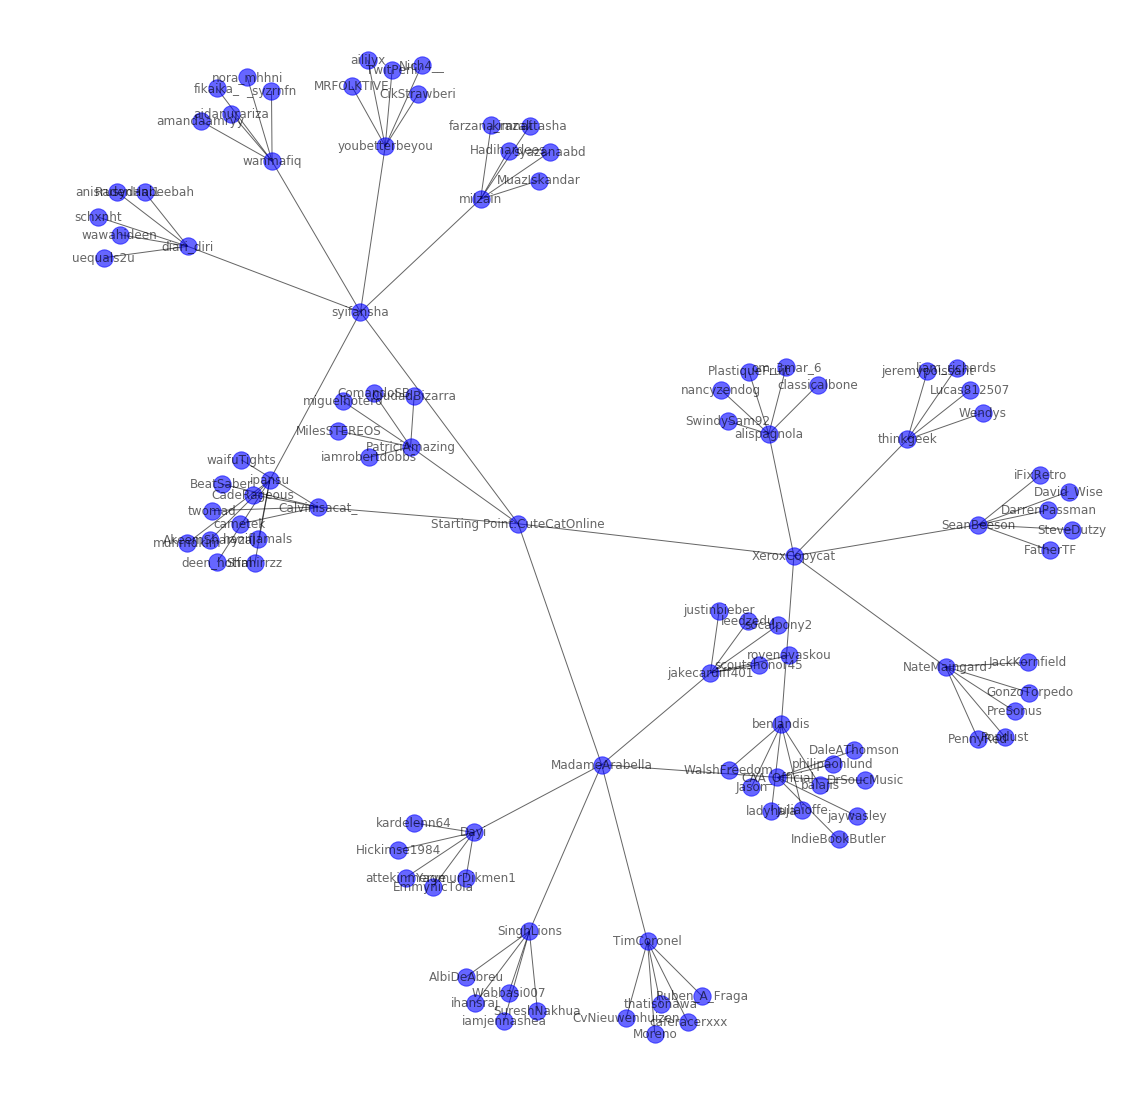

In [23]:
# Create a social network based on the results (nodes and edges)
# using the Networkx package, adding all the nodes and edges.
import networkx as nx
import matplotlib.pyplot as plt

# create network graph
G = nx.Graph()

# add nodes
for node in nodes:
    node_name = get_user_profile(twitter_api, user_ids=[node]).get(node).get('screen_name')
    if (node_name == screen_name):
        node_name = 'Starting Point:' + node_name
    G.add_node(node, label_name = node_name)
# add edges
G.add_edges_from(edges)

# draw graph
network_graph = plt.figure(figsize=(15,15))
nx.draw(G, with_labels=True, labels=nx.get_node_attributes(G, 'label_name'), alpha=0.6, node_color='blue')
plt.savefig("network_graph.png")
plt.show()

In [24]:
# 7. Calculate the diameter and average distance of the network
#    using built-in functions provided by Networkx.

# Get Network Size
print("Total number of nodes is: ", len(nodes))
print("Total number of edges is: ", len(edges))
print("The diameter of the network graph is:", nx.diameter(G))
print("The average distance of the network graph is:", round(nx.average_shortest_path_length(G),2))

# Save Network Graph

f=open("Network_Info.txt","w+")
f.write("Network Graph Information Detail: \r\n")
f.write("Total number of nodes is: %d\r\n" % len(nodes))
f.write("Total number of edges is: %d\r\n" % len(edges))
f.write("The diameter of the network graph is: %d\r\n" % nx.diameter(G))
f.write("The average distance of the network graph is: %a\r\n" % round(nx.average_shortest_path_length(G),2))
f.close()

Total number of nodes is:  105
Total number of edges is:  104
The diameter of the network graph is: 6
The average distance of the network graph is: 4.68


In [ ]:
# end of data mining project for Twitter